In [81]:
#import block
from dask.distributed import Client
client = Client(n_workers=4)
import dask.array as da
from dask import delayed
import dask.dataframe as dd

In [14]:
client.ncores

<bound method Client.nthreads of <Client: 'tcp://127.0.0.1:55880' processes=4 threads=8, memory=16.91 GB>>

In [80]:
client.close()

In [13]:
# translating

In [419]:
#import block 
import pandas as pd
import os
import uuid
import datetime
from enum import Enum 
import dateutil
import numpy as np
import itertools

In [420]:
df_invoice = pd.read_csv('invoice.csv')
df_line_item = pd.read_csv('line_item.csv')
df_invoice['invoice_date'] = pd.to_datetime(df_invoice['invoice_date'], format='%Y-%m-%d')
df_invoice['period_start_date'] = pd.to_datetime(df_invoice['period_start_date'], format='%Y-%m-%d')
df_invoice['period_end_date'] = pd.to_datetime(df_invoice['period_end_date'], format='%Y-%m-%d')
df_line_item['period_end_date'] = pd.to_datetime(df_line_item['period_end_date'], format='%Y-%m-%d')
#df_invoice = dd.from_pandas(df_invoice, npartitions = 3)

In [421]:
class glean_type(Enum):
    vendor_not_seen_in_a_while = 'vendor_not_seen_in_a_while'
    accrual_alert ='accrual_alert' 
    large_month_increase_mtd ='large_month_increase_mtd' 
    no_invoice_received = 'no_invoice_received'

class glean_location(Enum):
    invoice = 'invoice'
    vendor = 'vendor'

In [422]:
def logic_1(vendor_id):
    temp_df = df_invoice.loc[df_invoice['canonical_vendor_id'] == vendor_id][:]
    if len(temp_df) <= 1:
        return None
    temp_df = temp_df.sort_values(by=[ 'invoice_date'])
    temp_df_x = temp_df[:-1].copy()
    temp_df_y = temp_df[1:].copy()
    temp_df_x.columns =list(map(lambda x: x +'_x', temp_df_x.columns))
    temp_df_y.columns = list(map(lambda x: x +'_y', temp_df_y.columns))
    temp_df = pd.concat([temp_df_x.reset_index(drop=True), temp_df_y.reset_index(drop=True)], axis=1)
    temp_df['days_passed'] = temp_df.invoice_date_y - temp_df.invoice_date_x
    temp_df = temp_df.loc[temp_df['days_passed']>datetime.timedelta(days = 90)]
    if len(temp_df)> 0:
        end_date = temp_df.invoice_date_y
        start_date = temp_df.invoice_date_x
        months = list(map(lambda x,y:str((y.year - x.year) * 12 + (y.month - x.month)),start_date, end_date ))
        glean_text = list(map(lambda x: 'First new bill in '+ x  + ' months from vendor ' +vendor_id, months))
        temp_df['glean_text'] = glean_text
        temp_df= temp_df.loc[:,['invoice_id_y', 'canonical_vendor_id_y','glean_text']]
        temp_df.columns = ['invoice_id', 'canonical_vendor_id','glean_text']
        # adding standard enteries 
        temp_df['glean_type'] = list(map(lambda x: glean_type.vendor_not_seen_in_a_while.value, range(len(temp_df))))
        temp_df['glean_location'] = list(map(lambda x: glean_location.invoice.value, range(len(temp_df))))
        temp_df['glean_date'] = list(map(lambda x: datetime.date.today().isoformat(), range(len(temp_df))))
        temp_df['glean_id'] = list(map(lambda x: str(uuid.uuid1()), range(len(temp_df))))
        temp_df = temp_df[['glean_id','glean_date','glean_text','glean_type','glean_location','invoice_id', 'canonical_vendor_id']]
        return temp_df
    else:
        return None 

In [423]:
%%time
result_logic_1 = []
result_logic_1 = list(map(lambda x: delayed(logic_1)(x) ,set(df_invoice.canonical_vendor_id[:])))
result_logic_1 = list(filter(None.__ne__, result_logic_1))
result_logic_1 = delayed(pd.concat)(result_logic_1)


Wall time: 20 ms


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.982725 to fit


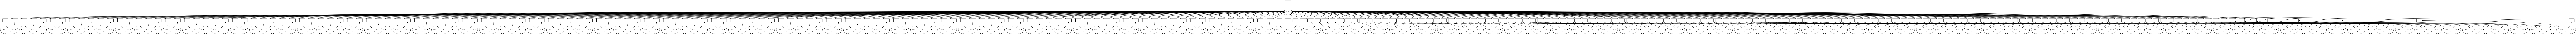

In [424]:
#sample visualizing just 5
result_logic_1.visualize()

In [425]:
%%time
#result_logic_1 = result_logic_1.compute()
result_logic_1

Wall time: 0 ns


Delayed('concat-a0f0a0f8-f58f-4410-b45f-59a8f412abc9')

In [426]:
def logic_2_part_1(row):
    temp_result = {}
    temp_result['glean_id'] = []
    temp_result['glean_date'] = []
    temp_result['glean_text'] = []
    temp_result['glean_type'] = []
    temp_result['glean_location'] = []
    temp_result['invoice_id'] = []
    temp_result['canonical_vendor_id'] = []
    if (row['period_end_date'] - row['invoice_date'])  > datetime.timedelta(days = 90):
        temp_result['glean_id'].append(str(uuid.uuid1()))
        temp_result['glean_date'].append(datetime.date.today().isoformat())
        #glean_text logic
        glean_text = 'Line items from vendor '+row['canonical_vendor_id'] +' in this invoice cover future periods (through '+str(row['period_end_date'].strftime('%Y-%m-%d'))+' )'
        temp_result['glean_text'].append(glean_text)
        temp_result['glean_type'].append(glean_type.accrual_alert.value)
        temp_result['glean_location'].append(glean_location.invoice.value)
        temp_result['invoice_id'].append(row['invoice_id'])
        temp_result['canonical_vendor_id'].append(row['canonical_vendor_id'])
        return pd.DataFrame(temp_result)

In [427]:
%%time
result_logic_2_part_1 = []
rows =list(map(lambda x: df_invoice.iloc[x,:], range(len(df_invoice))))
result_logic_2_part_1 = list(map(lambda x: delayed(logic_2_part_1)(x) ,rows))
result_logic_2_part_1 = list(filter(None.__ne__, result_logic_2_part_1))
result_logic_2_part_1 = delayed(pd.concat)(result_logic_2_part_1)

Wall time: 567 ms


In [428]:
%%time
#result_logic_2_part_1 = result_logic_2_part_1.compute()
result_logic_2_part_1

Wall time: 0 ns


Delayed('concat-1e6f0c8e-6592-4fdc-b698-504126364d18')

In [429]:
result = pd.merge(df_line_item, df_invoice,how='left', on='invoice_id')
result = result.iloc[:,[0,1,2,3,4,5,6,7,11]]
result['days_passed'] = result.period_end_date_x -  result.invoice_date
result = result.loc[result['days_passed'] > datetime.timedelta(days = 90)]


In [430]:
def logic_2_part_2(vendor_id):
        temp_result = {}
        temp_result['glean_id'] = []
        temp_result['glean_date'] = []
        temp_result['glean_text'] = []
        temp_result['glean_type'] = []
        temp_result['glean_location'] = []
        temp_result['invoice_id'] = []
        temp_result['canonical_vendor_id'] = []
     
        row = result.loc[result['canonical_vendor_id'] == vendor_id].iloc[-1,:]
        temp_result['glean_id'].append(str(uuid.uuid1()))
        temp_result['glean_date'].append(datetime.date.today().isoformat())
        #glean_text logic
        glean_text = 'Line items from vendor '+row['canonical_vendor_id'] +' in this invoice cover future periods (through '+str(row['period_end_date_x'].strftime('%Y-%m-%d'))+' )'            
        
        temp_result['glean_text'].append(glean_text)
        temp_result['glean_type'].append(glean_type.accrual_alert.value)
        temp_result['glean_location'].append(glean_location.invoice.value)
        temp_result['invoice_id'].append(row['invoice_id'])
        temp_result['canonical_vendor_id'].append(row['canonical_vendor_id'])
        return pd.DataFrame(temp_result)

In [431]:
logic_2_part_2('089685a6-ecec-44ab-bfdf-b2ccb5182382')

,glean_id,glean_date,glean_text,glean_type,glean_location,invoice_id,canonical_vendor_id
0,9004d6da-4325-11eb-83fd-2016b9350fa1,2020-12-20,Line items from vendor 089685a6-ecec-44ab-bfdf...,accrual_alert,invoice,a205f7ca-d7ae-4c52-a6ac-8eb9e32a588f,089685a6-ecec-44ab-bfdf-b2ccb5182382


In [432]:
%%time
result_logic_2_part_2 = []
result_logic_2_part_2 = list(map(lambda x: delayed(logic_2_part_2)(x) ,set(result.canonical_vendor_id)))
result_logic_2_part_2 = list(filter(None.__ne__, result_logic_2_part_2))
result_logic_2_part_2 = delayed(pd.concat)(result_logic_2_part_2)

Wall time: 9 ms


In [433]:
%%time
#result_logic_2_part_2 = result_logic_2_part_2.compute()
result_logic_2_part_2

Wall time: 0 ns


Delayed('concat-31bfbd06-95ed-4b43-abd6-8db8fb438bf6')

In [434]:
def logic_3(vendor_id):
    temp_result = {}
    temp_result['glean_id'] = []
    temp_result['glean_date'] = []
    temp_result['glean_text'] = []
    temp_result['glean_type'] = []
    temp_result['glean_location'] = []
    temp_result['invoice_id'] = []
    temp_result['canonical_vendor_id'] = []    
    vendor_specific_df = result.loc[result['canonical_vendor_id'] == vendor_id]
    invoice_dates = list(set(result.loc[result['canonical_vendor_id'] == vendor_id].invoice_date))
    invoice_dates = set(list(map(lambda x: datetime.date(x.year, x.month ,1),invoice_dates  ))) # one per month
    for date in invoice_dates:
        date = datetime.date(date.year, date.month ,1)
        ending_of_range = date +  dateutil.relativedelta.relativedelta(months=1)
        current_month_starting = ending_of_range - dateutil.relativedelta.relativedelta(months=1)
        starting_of_range =  ending_of_range -  dateutil.relativedelta.relativedelta(months=12) #<=
        vendor_specific_current_month_df = vendor_specific_df[(vendor_specific_df['invoice_date'] >= current_month_starting.isoformat()) & (vendor_specific_df['invoice_date'] < ending_of_range.isoformat())]
        vendor_specific_past_12_month_df = vendor_specific_df[(vendor_specific_df['invoice_date'] >= starting_of_range.isoformat()) & (vendor_specific_df['invoice_date'] < ending_of_range.isoformat())]
        monthly_bill = vendor_specific_current_month_df.total_amount_x.sum()
        average_bill_12_months = vendor_specific_past_12_month_df.total_amount_x.mean()
        
        
        check_condition = False
        #glean_text logic
        #glean_text = 'Monthly spend with '+vendor_id +' is $'+ str(monthly_bill)+' '+ str((monthly_bill/average_bill_12_months)*100) + '% higher than average'
        #condition 1
        if ((monthly_bill > 10000) and ((monthly_bill - average_bill_12_months) > (0.5 *average_bill_12_months))):    
            check_condition = True
            glean_text = 'Monthly spend with '+vendor_id +' is $'+ str(round(monthly_bill,2))+' ('+ str(round((monthly_bill/average_bill_12_months)*100,2)) + '%) higher than average'
        #condition 2
        if ( (monthly_bill < 10000) and ((monthly_bill - average_bill_12_months) > (2*average_bill_12_months)) and (monthly_bill > 100) ):
            check_condition = True
            glean_text = 'Monthly spend with '+vendor_id +' is $'+ str(round(monthly_bill,2))+' ('+ str(round((monthly_bill/average_bill_12_months)*100,2)) + '%) higher than average'
        #condtion 3
        if ((monthly_bill < 1000) and ((monthly_bill - average_bill_12_months) > (5*average_bill_12_months))and (monthly_bill > 100)):
            check_condition = True
            glean_text = 'Monthly spend with '+vendor_id +' is $'+ str(round(monthly_bill,2))+' ('+ str(round((monthly_bill/average_bill_12_months)*100,2)) + '%) higher than average'        
        
        if check_condition:
            temp_result['glean_id'].append(str(uuid.uuid1()))
            temp_result['glean_date'].append(datetime.date.today().isoformat())
            temp_result['glean_text'].append(glean_text)
            temp_result['glean_type'].append(glean_type.large_month_increase_mtd.value)
            temp_result['glean_location'].append(glean_location.vendor.value)
            temp_result['invoice_id'].append(np.nan)
            temp_result['canonical_vendor_id'].append(vendor_id)
            temp_result_df = pd.DataFrame(temp_result)
            return temp_result_df

In [435]:
%%time
result_logic_3 = []
result_logic_3 = list(map(lambda x: delayed(logic_3)(x) ,set(result.canonical_vendor_id)))
result_logic_3 = list(filter(None.__ne__, result_logic_3))
result_logic_3 = delayed(pd.concat)(result_logic_3)

Wall time: 5 ms


In [436]:
%%time
#result_logic_3 = result_logic_3.compute()
result_logic_3

Wall time: 0 ns


Delayed('concat-d951de09-9f8b-4e65-86ec-27f948a52f06')

In [437]:
%%time
output = delayed(pd.concat)([result_logic_1,result_logic_2_part_1,result_logic_2_part_2,result_logic_3])
output = output.compute()
output

Wall time: 6.7 s


,glean_id,glean_date,glean_text,glean_type,glean_location,invoice_id,canonical_vendor_id
0,945b0b0c-4325-11eb-9113-2016b9350fa1,2020-12-20,First new bill in 10 months from vendor 257bfd...,vendor_not_seen_in_a_while,invoice,09032da5-8c7b-4e1f-b721-ca680711eb15,257bfd04-398c-4762-9c14-e0cdf8f26dfd
0,9434e578-4325-11eb-b955-2016b9350fa1,2020-12-20,First new bill in 5 months from vendor a77018f...,vendor_not_seen_in_a_while,invoice,516813f6-610c-4d79-9f65-2a37068310dd,a77018fe-ac76-45bd-a716-fe514eccff4c
1,9434e579-4325-11eb-9771-2016b9350fa1,2020-12-20,First new bill in 14 months from vendor a77018...,vendor_not_seen_in_a_while,invoice,60f5c828-dec2-4315-8f19-9ab8904c99c3,a77018fe-ac76-45bd-a716-fe514eccff4c
0,945fcfa8-4325-11eb-a5bc-2016b9350fa1,2020-12-20,First new bill in 10 months from vendor 8f3ae1...,vendor_not_seen_in_a_while,invoice,d1a6beb8-12d4-456a-a0b4-0e7340ad504d,8f3ae183-3da9-4113-b432-e559dcba8f1c
2,945fcfa9-4325-11eb-a4b1-2016b9350fa1,2020-12-20,First new bill in 3 months from vendor 8f3ae18...,vendor_not_seen_in_a_while,invoice,ac37194f-7d1f-4ed9-92cf-973dc0321d3f,8f3ae183-3da9-4113-b432-e559dcba8f1c
...,...,...,...,...,...,...,...
0,951bba39-4325-11eb-91ae-2016b9350fa1,2020-12-20,Monthly spend with cbbee2fb-061a-40b0-ad51-94a...,large_month_increase_mtd,vendor,NaN,cbbee2fb-061a-40b0-ad51-94a8d286a0a4
0,94ef8524-4325-11eb-b490-2016b9350fa1,2020-12-20,Monthly spend with e2091bc3-f9d7-4647-a1db-1f6...,large_month_increase_mtd,vendor,NaN,e2091bc3-f9d7-4647-a1db-1f648b438b74
0,9501806c-4325-11eb-94c5-2016b9350fa1,2020-12-20,Monthly spend with a5883740-aea5-4716-8f07-7b4...,large_month_increase_mtd,vendor,NaN,a5883740-aea5-4716-8f07-7b4765cb2385
0,951957cd-4325-11eb-a0a9-2016b9350fa1,2020-12-20,Monthly spend with c29760e1-5fa1-4346-9b34-4d3...,large_month_increase_mtd,vendor,NaN,c29760e1-5fa1-4346-9b34-4d3d96e12db8


True